Extraction and analysis of web scraped stash tab ids. 

This process is necessary to establish with high precision each API call datetime. Infact, the API does not provide any time related informations, given the usual use case; instead, following studies regarding the market price of currencies, similar to the real Stock Market, temporal data is of extreme relevance.

In [4]:
from datetime import datetime
import operator

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_filter1d

# Load data

In [31]:
%matplotlib inline

STATS_FILE = "../../data/next_change_id/web_scraping_results.txt"
# load data
with open(STATS_FILE) as file:
    content = [f.strip() for f in file.readlines()]

In [5]:
# put data into a pandas dataframe
scraping_data = pd.DataFrame([(row[0] + ' ' + row[1],
    row[2], row[3], row[4]) for row in [row.split(' ') for row in content]], 
    columns=["datetime", "next_change_id", "git_hyp", "steam_charts"])

In [7]:
scraping_data.sample(10)

,datetime,next_change_id,git_hyp,steam_charts
381,09/22/2019 17:00:00,NONE,43510,NONE
22,09/07/2019 18:00:00,477880063-494432640-466857798-533869564-507276156,69593,69397
417,09/24/2019 05:00:00,494010146-511096241-482351298-551582054-524042787,15323,15442
378,09/22/2019 14:00:00,NONE,38300,NONE
201,09/15/2019 05:00:00,485592523-502333610-474205724-542462017-515375804,26525,26253
326,09/20/2019 10:00:00,490394097-507450531-478827864-547679095-520310006,19444,19264
131,09/12/2019 07:00:00,482588306-499140130-471314114-539031887-512201609,21912,34832
281,09/18/2019 13:00:00,488831797-505826065-477276387-545992249-518683468,25215,24967
372,09/22/2019 08:00:00,NONE,24204,NONE
198,09/15/2019 02:00:00,485476462-502198655-474096047-542337566-515257641,30213,29958


# Fill missing values

In [8]:
scraping_data.git_hyp = scraping_data.git_hyp.astype(int)

scraping_data.steam_charts = scraping_data.steam_charts.apply(lambda y: None if y == 'NONE' else y)
scraping_data.steam_charts.fillna(value=0, inplace=True)
scraping_data.steam_charts = scraping_data.steam_charts.astype(int)

In [9]:
scraping_data.datetime = pd.to_datetime(scraping_data.datetime, format="%m/%d/%Y %H:%M:%S")

In [10]:
scraping_data.next_change_id = scraping_data.next_change_id.apply(lambda y: y if y != 'NONE' else None)
missing_next_change_id = scraping_data[scraping_data.next_change_id.isnull()].datetime

# forward fill
temp_1 = dict()
for k, v in scraping_data[scraping_data.next_change_id.isnull()].iterrows():
    if k > 24:
        if scraping_data.at[k-1, 'next_change_id'] is not None:
            a = [int(elem) for elem in scraping_data.at[k-1, 'next_change_id'].split('-')]
        else:
            a = temp_1[k-1]
        
        if scraping_data.at[k-24, 'next_change_id'] is not None:
            b = [int(elem) for elem in scraping_data.at[k-24, 'next_change_id'].split('-')]
        else:
            b = temp_1[k-24]
        
        if scraping_data.at[k-25, 'next_change_id'] is not None:
            c = [int(elem) for elem in scraping_data.at[k-25, 'next_change_id'].split('-')]
        else:
            c = temp_1[k-25]
            
        # a + (b - c)
        temp_1[k] = list(map(operator.add, a, map(operator.sub, b, c)))
        
# backward fill
temp_2 = dict()
for k, v in scraping_data[scraping_data.next_change_id.isnull()].iloc[::-1].iterrows():
    if k < len(scraping_data) - 25:
        if scraping_data.at[k+1, 'next_change_id'] is not None:
            a = [int(elem) for elem in scraping_data.at[k+1, 'next_change_id'].split('-')]
        else:
            a = temp_2[k+1]
        
        if scraping_data.at[k+25, 'next_change_id'] is not None:
            b = [int(elem) for elem in scraping_data.at[k+25, 'next_change_id'].split('-')]
        else:
            b = temp_2[k+25]
        
        if scraping_data.at[k+24, 'next_change_id'] is not None:
            c = [int(elem) for elem in scraping_data.at[k+24, 'next_change_id'].split('-')]
        else:
            c = temp_2[k+24]
        
        # a - (b - c)
        temp_2[k] = list(map(operator.sub, a, map(operator.sub, b, c)))

In [11]:
# set an itermediate new next_change_id computed on both forward  and backward parsed data
for k, v in scraping_data[scraping_data.next_change_id.isnull()].iterrows():    
    bfills = 0
    ffills = 0
    
    i = 0
    while k - i in temp_1.keys():
        bfills += 1
        i+=1
        
    i = 0
    while k + i in temp_2.keys():
        ffills += 1
        i+=1
    
    tot_fills = bfills + ffills
    bfill_rel = 1 - bfills / tot_fills
    ffill_rel = 1 - ffills / tot_fills
        
    i = 0
    res = [0] * 5
    
    if k in temp_1.keys():
        if tot_fills == 1:
            res = list(map(operator.add, res, [int(val) for val in temp_1[k]]))
        else:
            res = list(map(operator.add, res, [int(val * bfill_rel) for val in temp_1[k]]))
        i += 1
    
    if k in temp_2.keys():
        if tot_fills == 1:
            res = list(map(operator.add, res, [int(val) for val in temp_2[k]]))
        else:
            res = list(map(operator.add, res, [int(val * ffill_rel) for val in temp_2[k]]))
        i += 1
        
    scraping_data.at[k, 'next_change_id'] = '-'.join([str(elem) for elem in res])    

In [12]:
k = 363
print("\t", scraping_data.iloc[k-1].next_change_id, "\n\t", scraping_data.iloc[k].next_change_id, "\n\t", scraping_data.iloc[k+1].next_change_id)

	 491942989-509005317-480348324-549329155-521910478 
	 491976791-509040000-480379998-549367012-521945472 
	 492015119-509080608-480419200-549408404-521985645


In [30]:
scraping_data[['datetime', 'next_change_id']].to_csv('../../data/next_change_id/next_change_id_cleaned.csv')

## Git Hyp & Steam charts plotting

In [13]:
X = scraping_data.datetime

Y1 = scraping_data.git_hyp.values
Y2 = scraping_data.steam_charts

/home/fabio/.conda/envs/main/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


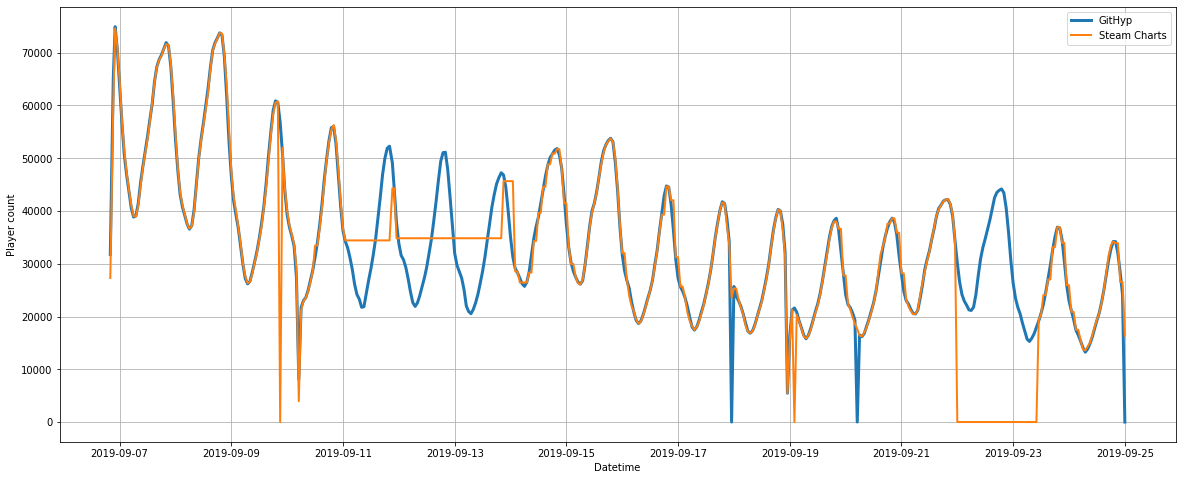

In [14]:
plt.figure(figsize=(20,8))

plt.xlabel('Datetime')
plt.ylabel('Player count')

plt.grid()

plt.plot(X, Y1, linewidth=3)
plt.plot(X, Y2, linewidth=2)

plt.legend(['GitHyp', 'Steam Charts'])

plt.show()

### Smoothing curves

In [15]:
Y1smooth = gaussian_filter1d(Y1, sigma=2)
Y2smooth = gaussian_filter1d(Y2, sigma=2)

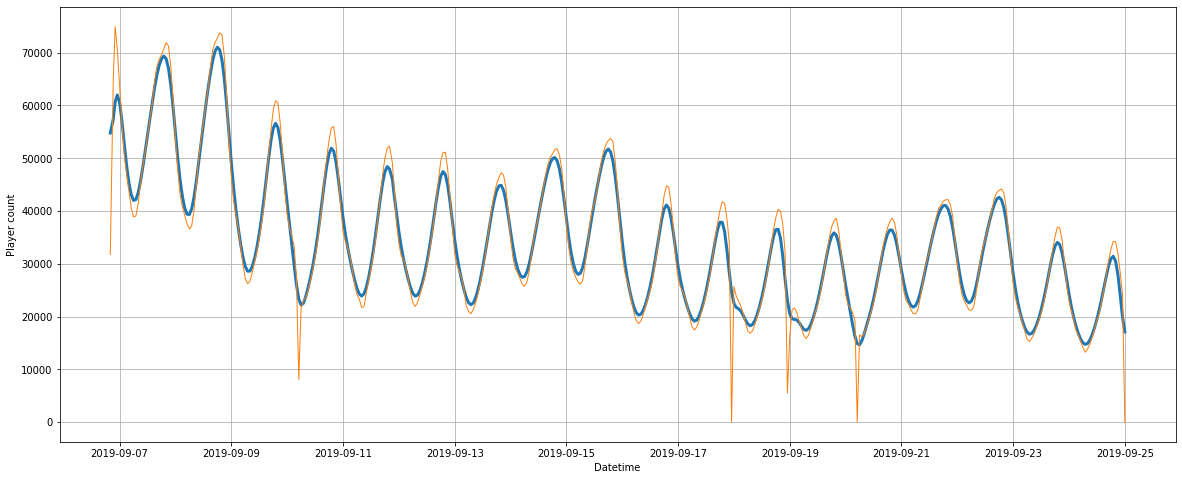

In [16]:
plt.figure(figsize=(20,8))

plt.xlabel('Datetime')
plt.ylabel('Player count')

plt.grid()

plt.plot(X, Y1smooth, linewidth=3)
plt.plot(X, Y1, linewidth=1)
plt.show()

## NextChangeId

In [17]:
nci_data = pd.DataFrame(
    tuple(scraping_data.next_change_id.apply(lambda y: y.split('-'))))

nci_data[0] = nci_data[0].astype(int)
nci_data[1] = nci_data[1].astype(int)
nci_data[2] = nci_data[2].astype(int)
nci_data[3] = nci_data[3].astype(int)
nci_data[4] = nci_data[4].astype(int)

In [18]:
nci_data['0_diff'] = nci_data[0].values - ([nci_data[0].values[0]]+(list(nci_data[0].values[0:-1])))
nci_data['1_diff'] = nci_data[1].values - ([nci_data[1].values[0]]+(list(nci_data[1].values[0:-1])))
nci_data['2_diff'] = nci_data[2].values - ([nci_data[2].values[0]]+(list(nci_data[2].values[0:-1])))
nci_data['3_diff'] = nci_data[3].values - ([nci_data[3].values[0]]+(list(nci_data[3].values[0:-1])))
nci_data['4_diff'] = nci_data[4].values - ([nci_data[4].values[0]]+(list(nci_data[4].values[0:-1])))

In [19]:
Y1 = nci_data['0_diff'].loc[1:]
Y2 = nci_data['1_diff'].loc[1:]
Y3 = nci_data['2_diff'].loc[1:]
Y4 = nci_data['3_diff'].loc[1:]
Y5 = nci_data['4_diff'].loc[1:]

X = scraping_data.datetime.loc[1:]

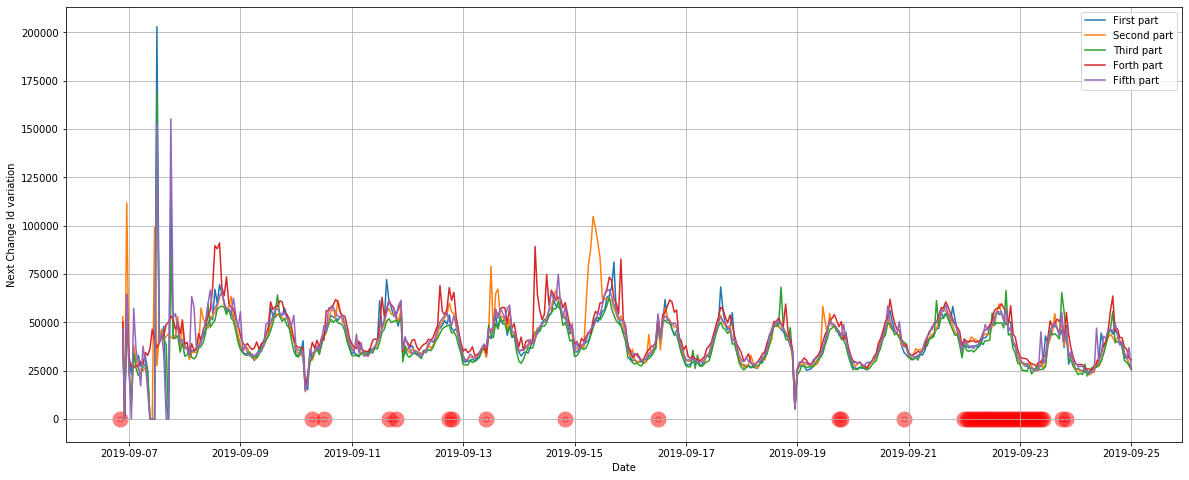

In [20]:
plt.figure(figsize=(20,8))
plt.grid()

plt.xlabel('Date')
plt.ylabel('Next Change Id variation')

plt.plot(X, Y1)
plt.plot(X, Y2)
plt.plot(X, Y3)
plt.plot(X, Y4)
plt.plot(X, Y5)

plt.scatter(missing_next_change_id, [0]*len(missing_next_change_id), color='red', alpha=0.5, linewidths=10)

plt.legend(labels=['First part', 'Second part', 'Third part', 'Forth part', 'Fifth part'])

plt.show()

In [21]:
Y = [int((a+b+c+d+e ) / 5) for a, b, c, d, e in zip(Y1, Y2, Y3, Y4, Y5)]
Ysmooth = gaussian_filter1d(Y, sigma=1.5)

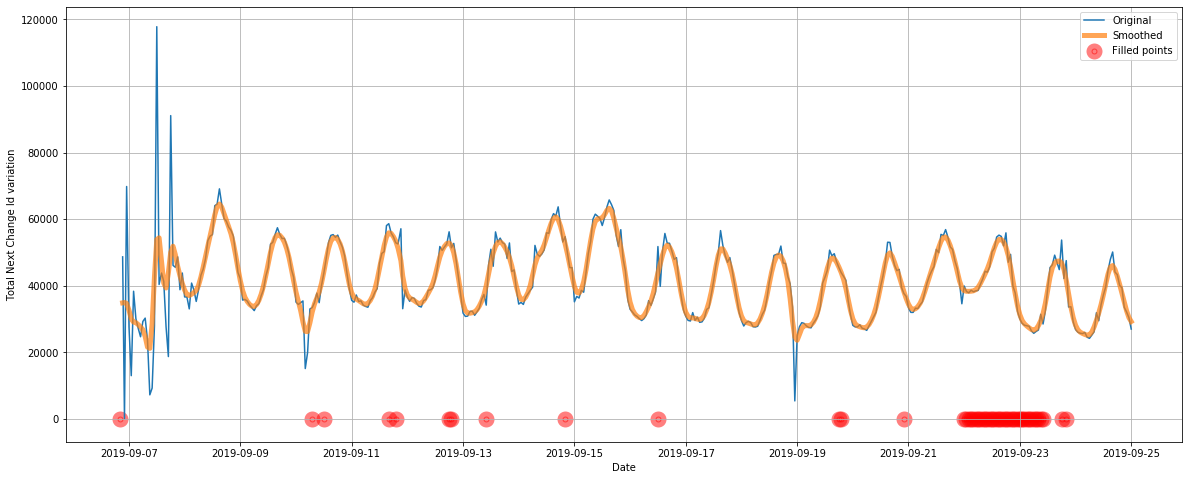

In [22]:
plt.figure(figsize=(20,8))
plt.grid()

plt.xlabel('Date')
plt.ylabel('Total Next Change Id variation')

plt.plot(X, Y)
plt.plot(X, Ysmooth, linewidth=5, alpha=0.7)

plt.scatter(missing_next_change_id, [0]*len(missing_next_change_id), color='red', alpha=0.5, linewidths=10)

plt.legend(labels=['Original', 'Smoothed', 'Filled points'])

plt.show()

In [23]:
scraping_data.to_csv('web_scraping_results_cleaned.csv', index=False, columns=['datetime', 'next_change_id', 'git_hyp'])